# **Data Analysis on Ischaemic Heart Disease**

In 2019, the World Health Organization (WHO) declared that Ischaemic Heart Disease is the leading cause of death worldwide, accounting for 16% of all deaths <sup>[1]</sup>. They also mentioned that annual deaths among men were around 15% more than women <sup>[2]</sup>.

## Table of Contents

1. <a href="#toc-01">Import Dataset and Data Transformation</a>
2. <a href="#toc-02">Exploratory Data Analysis</a>
3. <a href="#toc-03">Model Creation and Evaluation</a>
5. <a href="#toc-04">Make Test Predications</a>
6. <a href="#toc-05">References</a>

In [1153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import RobustScaler

import warnings
warnings.filterwarnings("ignore")

## Import Dataset and Data Transformation<a id="toc-01"></a>

Dataset for income grouping was taken from <a href="https://www.who.int/docs/default-source/gho-documents/global-health-estimates/ghe2019_cod_methods.pdf">WHO methods and data sources of country-level causes of death (p. 49)</a>.

After reading data from the source, all records with missing data under income_grouping will be dropped as this category is necessary for data analysis.

In [1154]:
income_grouping_2019 = pd.read_csv('./datasets/World Bank Income Grouping 2019.csv')

income_grouping_2019.dropna(inplace=True)   # Drop all rows with NaN values
income_grouping_2019.reset_index(inplace=True, drop=True)

income_grouping_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   region_code      109 non-null    object
 1   region_name      109 non-null    object
 2   country_code     109 non-null    object
 3   country_name     109 non-null    object
 4   income_grouping  109 non-null    object
dtypes: object(5)
memory usage: 4.4+ KB


Dataset for Ischaemic Heart Disease was taken from <a href="https://platform.who.int/mortality/themes/theme-details/topics/indicator-groups/indicator-group-details/MDB/ischaemic-heart-disease">WHO's interactive platform for mortality data</a>.

After reading data from the source, the records are filtered by
- <b>Sex</b>: Male and Female only (removing 'Unknown' and 'All' from the list)
- <b>Age Group</b>: Remove 'All' and 'Unknown'
- <b>Date Rate per 100,000</b>: Remove records with zero values

In [1155]:
ihd_df = pd.read_csv('./datasets/Ischaemic Heart Disease.csv')

ihd_df_filtered = ihd_df.fillna(0)  # Fill all NaN cells with 0
ihd_df_filtered = ihd_df_filtered.query("sex == ['Male', 'Female'] and age_group != ['[All]', '[Unknown]'] and death_rate_per_100000 != 0")

ihd_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130024 entries, 26 to 296602
Data columns (total 12 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   region_code                                           130024 non-null  object 
 1   region_name                                           130024 non-null  object 
 2   country_code                                          130024 non-null  object 
 3   country_name                                          130024 non-null  object 
 4   year                                                  130024 non-null  int64  
 5   sex                                                   130024 non-null  object 
 6   age_group_code                                        130024 non-null  object 
 7   age_group                                             130024 non-null  object 
 8   num_of_death                               

Merge the necessary fields from Ischeamic Heart Disease and Income Grouping tables

In [1156]:
ihd_with_ig_df = ihd_df_filtered[['country_code', 'year', 'sex', 'age_group', 'death_rate_per_100000']].merge(income_grouping_2019[['country_code', 'income_grouping']], on='country_code')

ihd_with_ig_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128634 entries, 0 to 128633
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country_code           128634 non-null  object 
 1   year                   128634 non-null  int64  
 2   sex                    128634 non-null  object 
 3   age_group              128634 non-null  object 
 4   death_rate_per_100000  128634 non-null  float64
 5   income_grouping        128634 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.9+ MB


Rename the age group category based from Statistics Canada's <a href="https://www.statcan.gc.ca/en/concepts/definitions/age2">Age Categories, Life Cycle Groupings</a>
- <b>Children</b>: 00-14 years
- <b>Youth</b>: 15-24 years
- <b>Adults</b>: 25-64 years
- <b>Seniors</b>: 65 years and over

The records for `Youth` and `Children` are combined in this study.

In [1157]:
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[0]', 'Children_Youth', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[1-4]', 'Children_Youth', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[5-9]', 'Children_Youth', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[10-14]', 'Children_Youth', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[15-19]', 'Children_Youth', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[20-24]', 'Children_Youth', ihd_with_ig_df['age_group'])

ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[25-29]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[30-34]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[35-39]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[40-44]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[45-49]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[50-54]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[55-59]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[60-64]', 'Adults', ihd_with_ig_df['age_group'])

ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[65-69]', 'Seniors', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[70-74]', 'Seniors', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[75-79]', 'Seniors', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[80-84]', 'Seniors', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[85+]', 'Seniors', ihd_with_ig_df['age_group'])

ihd_with_ig_df['age_group'].value_counts()

# ihd_with_ig_df.groupby(['age_group', 'sex'])['death_rate_per_100000'].describe()

Adults            65769
Seniors           43942
Children_Youth    18923
Name: age_group, dtype: int64

## Exploratory Data Analysis<a id="toc-02"></a>

### Data Analysis on Income Grouping per Year

Group the records by `income_grouping` then display the summary statistics of `death_rate_per_100000` for each `income_grouping`. 

**NOTE**: WHO didn't provide records for Low Income grouping. Hence, it is excluded from the study.

In [1158]:
ihd_with_ig_grp_income = ihd_with_ig_df.groupby(['income_grouping']) 

ihd_with_ig_grp_income['death_rate_per_100000'].describe()

,count,mean,std,min,25%,50%,75%,max
income_grouping,,,,,,,,
High Income,72034.0,634.031115,1351.363813,0.009323,5.190674,75.471698,599.296719,26000.00000
Low Middle Income,12629.0,840.326820,2079.669397,0.021894,4.356465,49.037783,476.644423,20608.95823
Upper Middle Income,43971.0,490.130301,1178.002267,0.011149,4.866173,62.043170,411.863951,19016.29073


Extract the records for `High Income` category. Aggregate them by `year` then get the mean of `death_rate_per_100000` for each year. Create separate dataframe for `year` and `death_rate_per_100000`.

In [1159]:
ihd_with_ig_grpby_high_income = ihd_with_ig_grp_income.get_group('High Income')
ihd_with_ig_grpby_high_income_and_year = ihd_with_ig_grpby_high_income[['year', 'death_rate_per_100000']].groupby('year', as_index=False).agg(death_rate_per_100000 = ('death_rate_per_100000', 'mean'))

year_by_high_income = ihd_with_ig_grpby_high_income_and_year['year']
death_rate_per_100000_by_high_income = ihd_with_ig_grpby_high_income_and_year['death_rate_per_100000']

ihd_with_ig_grpby_high_income_and_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   71 non-null     int64  
 1   death_rate_per_100000  71 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.2 KB


Extract the records for `Upper Middle Income` category. Aggregate them by `year` then get the mean of `death_rate_per_100000` for each year. Create separate dataframe for `year` and `death_rate_per_100000`.

In [1160]:
ihd_with_ig_grpby_upper_middle_income = ihd_with_ig_grp_income.get_group('Upper Middle Income')
ihd_with_ig_grpby_upper_middle_income_and_year = ihd_with_ig_grpby_upper_middle_income[['year', 'death_rate_per_100000']].groupby('year', as_index=False).agg(death_rate_per_100000 = ('death_rate_per_100000', 'mean'))

year_by_upper_mid_income = ihd_with_ig_grpby_upper_middle_income_and_year['year']
death_rate_per_100000_by_upper_mid_income = ihd_with_ig_grpby_upper_middle_income_and_year['death_rate_per_100000']

ihd_with_ig_grpby_upper_middle_income_and_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   68 non-null     int64  
 1   death_rate_per_100000  68 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.2 KB


Extract the records for `Low Middle Income` category. Aggregate them by `year` then get the mean of `death_rate_per_100000` for each year. Create separate dataframe for `year` and `death_rate_per_100000`.

In [1161]:
ihd_with_ig_grpby_low_middle_income = ihd_with_ig_grp_income.get_group('Low Middle Income')
ihd_with_ig_grpby_low_middle_income_and_year = ihd_with_ig_grpby_low_middle_income[['year', 'death_rate_per_100000']].groupby('year', as_index=False).agg(death_rate_per_100000 = ('death_rate_per_100000', 'mean'))

year_by_low_mid_income = ihd_with_ig_grpby_low_middle_income_and_year['year']
death_rate_per_100000_by_low_mid_income = ihd_with_ig_grpby_low_middle_income_and_year['death_rate_per_100000']

ihd_with_ig_grpby_low_middle_income_and_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   57 non-null     int64  
 1   death_rate_per_100000  57 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.0 KB


Plot on the scatterplot the `year` and `death_rate_per_100000` for each incoming grouping.

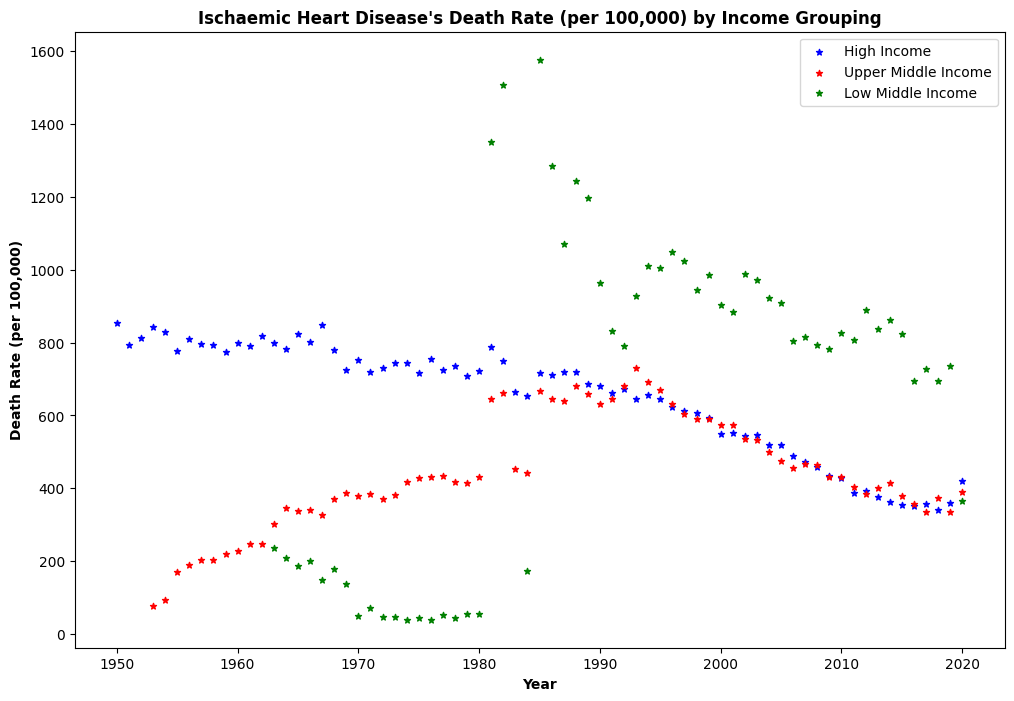

In [1162]:
# Plot the graph of Death Rate per 100000 for each Year based on Income Grouping
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.set_xlabel("Year", fontdict={'weight':'bold'})
ax.set_ylabel("Death Rate (per 100,000)", fontdict={'weight':'bold'})
ax.set_title("Ischaemic Heart Disease's Death Rate (per 100,000) by Income Grouping", fontdict={'size':'large', 'weight':'bold'})

ax.scatter(year_by_high_income, death_rate_per_100000_by_high_income, s=20, c='b', label='High Income', marker='*')
ax.scatter(year_by_upper_mid_income, death_rate_per_100000_by_upper_mid_income, s=20, c='r', label='Upper Middle Income', marker='*')
ax.scatter(year_by_low_mid_income, death_rate_per_100000_by_low_mid_income, s=20, c='g', label='Low Middle Income', marker='*')
ax.legend(loc='upper right')

Based from the results, death rate of Ischaemic Heart Disease under `High Income` is slowly decreasing over the past years. However, the death rate for `Low Middle Income` has surged in the mid 1980's, doubling the value of `High Income`. There's also an outlier data for year 2020 under Low Middle Income.


### Data Analysis on Sex per Year

Group the records by `sex` then display the summary statistics of `death_rate_per_100000` for each `sex`.

In [1163]:
ihd_with_ig_grp_sex = ihd_with_ig_df.groupby(['sex']) 

ihd_with_ig_grp_sex['death_rate_per_100000'].describe()  

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
Female,62545.0,514.430051,1285.773049,0.009741,3.423485,39.544638,369.276219,22333.33333
Male,66089.0,690.898283,1476.727641,0.009323,7.458976,107.988981,653.704324,26000.00000


Extract the records for `Male`. Aggregate them by `year` then get the mean of `death_rate_per_100000` for each year. Create separate dataframe for `year` and `death_rate_per_100000`.

In [1164]:
df_grpby_male = ihd_with_ig_grp_sex.get_group('Male')
df_grpby_male_and_year = df_grpby_male[['year', 'death_rate_per_100000']].groupby('year', as_index=False).agg(death_rate_per_100000 = ('death_rate_per_100000', 'mean'))

year_by_male = df_grpby_male_and_year['year']
death_rate_per_100000_by_male = df_grpby_male_and_year['death_rate_per_100000']

df_grpby_male_and_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   71 non-null     int64  
 1   death_rate_per_100000  71 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.2 KB


Extract the records for `Female`. Aggregate them by `year` then get the mean of `death_rate_per_100000` for each year. Create separate dataframe for `year` and `death_rate_per_100000`.

In [1165]:
df_grpby_female = ihd_with_ig_grp_sex.get_group('Female')
df_grpby_female_and_year = df_grpby_female[['year', 'death_rate_per_100000']].groupby('year', as_index=False).agg(death_rate_per_100000 = ('death_rate_per_100000', 'mean'))

year_by_female = df_grpby_female_and_year['year']
death_rate_per_100000_by_female = df_grpby_female_and_year['death_rate_per_100000']

df_grpby_female_and_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   71 non-null     int64  
 1   death_rate_per_100000  71 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.2 KB


Plot on the scatterplot the `year` and `death_rate_per_100000` for each gender.

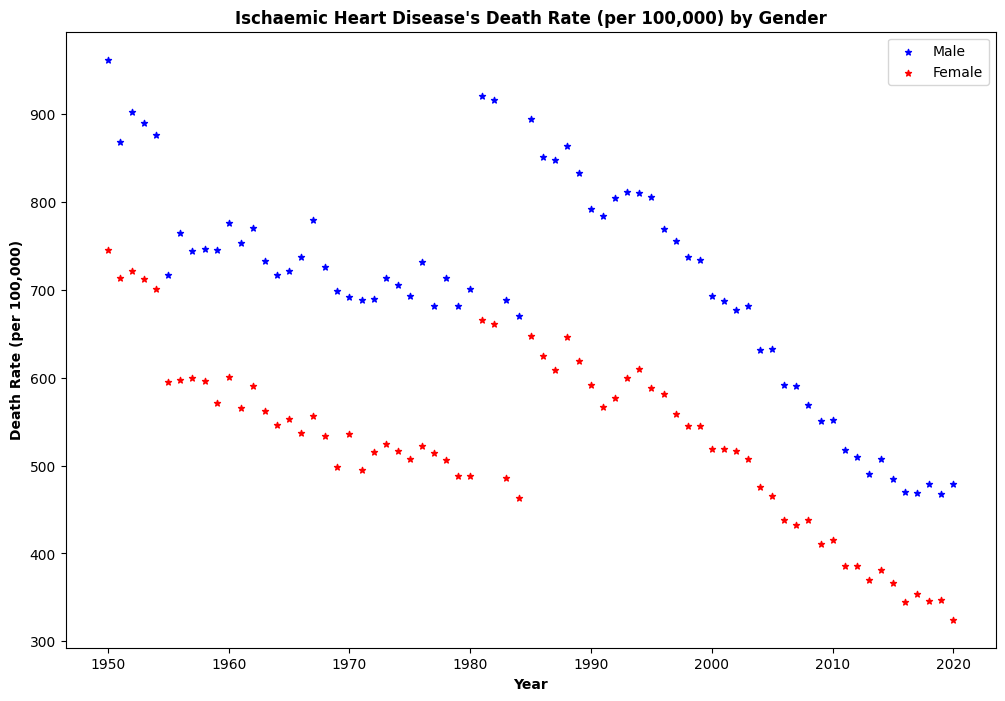

In [1166]:
# Plot the graph of Death Rate per 100000 for each Year based on Sex
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.set_xlabel("Year", fontdict={'weight':'bold'})
ax.set_ylabel("Death Rate (per 100,000)", fontdict={'weight':'bold'})
ax.set_title("Ischaemic Heart Disease's Death Rate (per 100,000) by Gender", fontdict={'size':'large', 'weight':'bold'})

ax.scatter(year_by_male, death_rate_per_100000_by_male, s=20, c='b', label='Male', marker='*')
ax.scatter(year_by_female, death_rate_per_100000_by_female, s=20, c='r', label='Female', marker='*')
ax.legend(loc='upper right')

Based from the results, `Male` has a higher death rate on Ischaemic Heart Disease as compared to `Female` though the mortality rate has decreased for both genders over the years. However, in the mid 1980s, there was a sudden shift of the number of death rates for male and female.

### Final Dataset

Data needs to be adjusted. Only those records from 1985 to 2019 will be used for the study, i.e. removing the outliers that might affect the accuracy and precision of the trained model.

In [1189]:
ihd_with_ig_df = pd.DataFrame(ihd_with_ig_df).query("year >= 1985 and year < 2020")
ihd_with_ig_df['year'].value_counts()

2009    2755
2003    2682
2002    2647
2001    2646
2010    2645
2000    2634
2011    2628
2007    2621
2008    2573
2004    2566
2014    2556
2006    2551
2012    2546
2005    2534
1999    2521
2013    2500
1998    2499
1997    2421
1996    2413
2016    2376
2015    2360
1995    2337
1987    2283
1994    2260
1992    2227
1993    2217
1986    2203
1990    2199
1985    2192
1991    2189
2017    2167
1988    2160
1989    2134
2018    2015
2019    1638
Name: year, dtype: int64

## Model Creation and Evaluation<a id="toc-03"></a>

### Data Preparation: Converting Categorical Features

Check the frequency counts of `income_grouping`, `sex` and `age_group`.

In [1168]:
ihd_with_ig_df['income_grouping'].value_counts()

High Income            41417
Upper Middle Income    32188
Low Middle Income      10913
Name: income_grouping, dtype: int64

In [1169]:
ihd_with_ig_df['sex'].value_counts()

Male      43528
Female    40990
Name: sex, dtype: int64

In [1170]:
ihd_with_ig_df['age_group'].value_counts()

Adults            43930
Seniors           29591
Children_Youth    10997
Name: age_group, dtype: int64

Convert `income_grouping`, `sex` and `age_group` to dummy variables with 0 or 1 as the value.

In [1171]:
income_grouping_df = pd.get_dummies(ihd_with_ig_df['income_grouping'])
income_grouping_df.columns = ['high_income', 'low_middle_income', 'upper_middle_income']
income_grouping_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84518 entries, 0 to 128633
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   high_income          84518 non-null  uint8
 1   low_middle_income    84518 non-null  uint8
 2   upper_middle_income  84518 non-null  uint8
dtypes: uint8(3)
memory usage: 907.9 KB


In [1172]:
male_gender_df = pd.get_dummies(ihd_with_ig_df['sex'], drop_first=True)
male_gender_df.columns = ['male_gender']
male_gender_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84518 entries, 0 to 128633
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   male_gender  84518 non-null  uint8
dtypes: uint8(1)
memory usage: 742.8 KB


In [1173]:
age_grouping_df = pd.get_dummies(ihd_with_ig_df['age_group'])
age_grouping_df.columns = ['adults', 'children_youth', 'seniors']
age_grouping_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84518 entries, 0 to 128633
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   adults          84518 non-null  uint8
 1   children_youth  84518 non-null  uint8
 2   seniors         84518 non-null  uint8
dtypes: uint8(3)
memory usage: 907.9 KB


Create a dummy dataframe. Drop `income_grouping`, `sex` and `age_group` and all unnecessary column(s) from the dummy dataframe.

In [1174]:
ihd_with_ig_df_dummy = ihd_with_ig_df.copy()
ihd_with_ig_df_dummy.drop(['country_code', 'sex', 'income_grouping', 'year', 'age_group'], axis=1, inplace=True)

ihd_with_ig_df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84518 entries, 0 to 128633
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   death_rate_per_100000  84518 non-null  float64
dtypes: float64(1)
memory usage: 1.3 MB


Concatenate in the dummy dataframe the dataframe (with dummy variables) created for `income_grouping`, `sex` and `age_group`.

In [1175]:
ihd_with_ig_df_dummy = pd.concat([ihd_with_ig_df_dummy, male_gender_df, age_grouping_df, income_grouping_df], axis=1, verify_integrity=True)
ihd_with_ig_df_dummy.head(5)

,death_rate_per_100000,male_gender,adults,children_youth,seniors,high_income,low_middle_income,upper_middle_income
0,0.617665,1,0,1,0,0,0,1
1,0.662252,1,0,1,0,0,0,1
2,4.040404,1,1,0,0,0,0,1
3,5.564388,1,1,0,0,0,0,1
4,5.213764,1,1,0,0,0,0,1


Check for independence between columns. The intensity of the feature's dependency is measured by the cell's color (more dependency -> darker color)

<AxesSubplot: >

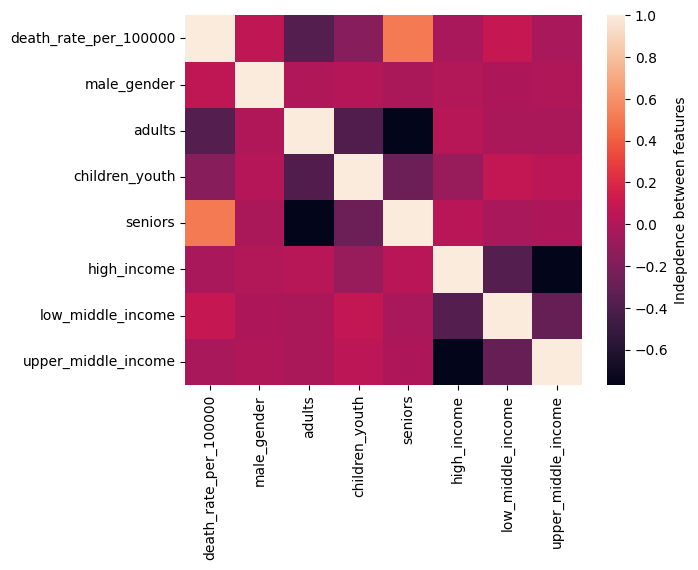

In [1176]:
# Check for independence between features
sb.heatmap(ihd_with_ig_df_dummy.corr(), cbar_kws={'label': 'Indepdence between features'})

### Function Declaration

In [1177]:
def evaluateModel(model, X_train, X_test, y_train, y_test):
    '''
    This method evaluate the Logistic Regression model and provide clasification report,
    confusion matrix and precision score
    '''
    y_pred_test = model.predict(X_test)
    
    print(f'Model score: {model.score(X_test, y_test)}')
    print()

    # Classification report without cross-validation
    print("Classification Report")
    print(classification_report(y_test, y_pred_test))
    print()

    # k-fold cross-validation and confusion matrices
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=5)

    cm = confusion_matrix(y_train, y_train_pred)
    cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], index=['Predict Positive:1', 'Predict Negative:0'])
    sb.heatmap(cm_matrix, annot=True, fmt='d')
    plt.title('Confusion Matrix')

    TP = cm[0,0]
    TN = cm[1,1]
    FP = cm[0,1]
    FN = cm[1,0]

    classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
    print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))

    classification_error = (FP + FN) / float(TP + TN + FP + FN)
    print('Classification error : {0:0.4f}'.format(classification_error))

    print(f"Precision Score: {precision_score(y_train, y_train_pred)}")

### Model Creation for Seniors Group

In [1178]:
X_train, X_test, y_train, y_test = train_test_split(ihd_with_ig_df_dummy.drop(['adults', 'children_youth', 'seniors'], axis=1), age_grouping_df['seniors'], test_size=0.3, random_state=0)

print(f"No. of train datasets: x={X_train.shape} y={y_train.shape}")
print(f"No. of test datasets: x={X_test.shape} y={y_test.shape}\n")

model_seniors = LogisticRegression(solver='lbfgs')
model_seniors.fit(X_train, y_train)

No. of train datasets: x=(59162, 5) y=(59162,)
No. of test datasets: x=(25356, 5) y=(25356,)



LogisticRegression()

### Model Evaluation for Seniors Group

Model score: 0.9017195141189462

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.96      0.93     16511
           1       0.92      0.79      0.85      8845

    accuracy                           0.90     25356
   macro avg       0.91      0.88      0.89     25356
weighted avg       0.90      0.90      0.90     25356


Classification accuracy : 0.9024
Classification error : 0.0976
Precision Score: 0.9166805810652864


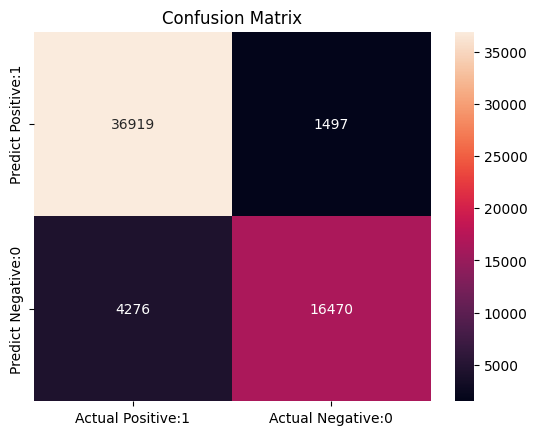

In [1179]:
evaluateModel(model_seniors, X_train, X_test, y_train, y_test)

### Model Creation for Adults Group

In [1180]:
X_train, X_test, y_train, y_test = train_test_split(ihd_with_ig_df_dummy.drop(['adults', 'children_youth', 'seniors'], axis=1), age_grouping_df['adults'], test_size=0.3, random_state=0)

print(f"No. of train datasets: x={X_train.shape} y={y_train.shape}")
print(f"No. of test datasets: x={X_test.shape} y={y_test.shape}\n")

model_adults = LogisticRegression(solver='lbfgs')
model_adults.fit(X_train, y_train)

No. of train datasets: x=(59162, 5) y=(59162,)
No. of test datasets: x=(25356, 5) y=(25356,)



LogisticRegression()

### Model Evaluation for Adults Group

Model score: 0.7707051585423569

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.60      0.72     12208
           1       0.72      0.93      0.81     13148

    accuracy                           0.77     25356
   macro avg       0.80      0.76      0.76     25356
weighted avg       0.80      0.77      0.76     25356


Classification accuracy : 0.7755
Classification error : 0.2245
Precision Score: 0.7211900609185814


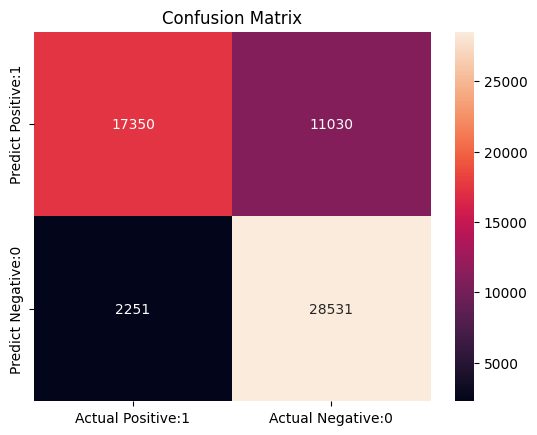

In [1181]:
evaluateModel(model_adults, X_train, X_test, y_train, y_test)

### Model Creation for Children/Youth Group

In [1182]:
X_train, X_test, y_train, y_test = train_test_split(ihd_with_ig_df_dummy.drop(['adults', 'children_youth', 'seniors'], axis=1), age_grouping_df['children_youth'], test_size=0.3, random_state=0)

print(f"No. of train datasets: x={X_train.shape} y={y_train.shape}")
print(f"No. of test datasets: x={X_test.shape} y={y_test.shape}\n")

model_children_youth = LogisticRegression(solver='lbfgs')
model_children_youth.fit(X_train, y_train)

No. of train datasets: x=(59162, 5) y=(59162,)
No. of test datasets: x=(25356, 5) y=(25356,)



LogisticRegression()

### Model Evaluation for Children/Youth Group

Model score: 0.9353999053478467

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     21993
           1       0.76      0.75      0.75      3363

    accuracy                           0.94     25356
   macro avg       0.86      0.86      0.86     25356
weighted avg       0.94      0.94      0.94     25356


Classification accuracy : 0.9359
Classification error : 0.0641
Precision Score: 0.7567531425514844


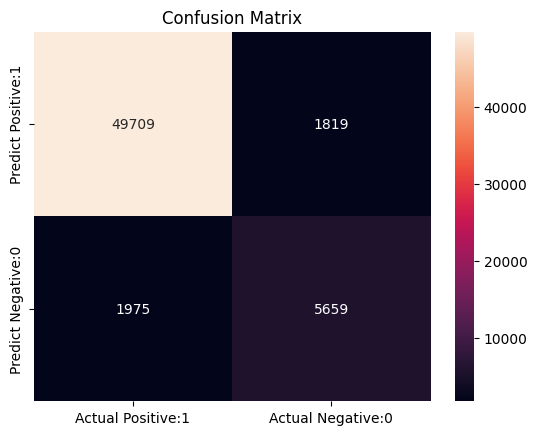

In [1183]:
evaluateModel(model_children_youth, X_train, X_test, y_train, y_test)

## Make Test Prediction<a id="toc-04"></a>

In [1215]:
def getPrediction(age_group, model, input):

    df = np.array(input).reshape(1,-1)

    percentage = round(model.predict_proba(df)[0][1] * 100, 2)
    print(f"{str(age_group + ' ').ljust(40, '.')} {percentage}%")


def testPrediction(models: dict, input: list):
    print(f"Gender: {'Male' if input[1] == 1 else 'Female'}")

    income_grouping = None
    if input[2] == 1:
        income_grouping = "High Income"
    elif input[3] == 1:
        income_grouping = "Upper Middle Income"
    elif input[4] == 1:
        income_grouping = "Low Middle Income"

    print(f"Income Grouping: {income_grouping}")
    print(f"Death Rate (per 100,000): {input[0]}")
    print()

    print("The likelihood that the data belongs to a specific age group\n")

    for elem in models.items():
        getPrediction(elem[0], elem[1], input)


In [1216]:
date_rate = 700
male_gender = 1
high_income = 0
upper_middle_income = 0
low_middle_income = 1

testPrediction({ 'Children/Youth': model_children_youth, 'Adults': model_adults, 'Seniors': model_seniors }, [date_rate, male_gender, high_income, upper_middle_income, low_middle_income])

Gender: Male
Income Grouping: Low Middle Income
Death Rate (per 100,000): 700

The likelihood that the data belongs to a specific age group

Children/Youth ......................... 0.0%
Adults ................................. 14.64%
Seniors ................................ 94.91%


In [1217]:
date_rate = 120
male_gender = 1
high_income = 0
upper_middle_income = 0
low_middle_income = 1

testPrediction({ 'Children/Youth': model_children_youth, 'Adults': model_adults, 'Seniors': model_seniors }, [date_rate, male_gender, high_income, upper_middle_income, low_middle_income])

Gender: Male
Income Grouping: Low Middle Income
Death Rate (per 100,000): 120

The likelihood that the data belongs to a specific age group

Children/Youth ......................... 0.0%
Adults ................................. 66.55%
Seniors ................................ 6.22%


In [1221]:
date_rate = 1
male_gender = 1
high_income = 1
upper_middle_income = 0
low_middle_income = 0

testPrediction({ 'Children/Youth': model_children_youth, 'Adults': model_adults, 'Seniors': model_seniors }, [date_rate, male_gender, high_income, upper_middle_income, low_middle_income])

Gender: Male
Income Grouping: High Income
Death Rate (per 100,000): 1

The likelihood that the data belongs to a specific age group

Children/Youth ......................... 56.61%
Adults ................................. 80.17%
Seniors ................................ 2.59%


## References<a id="toc-05"></a>

1. <a href="https://www.who.int/news-room/fact-sheets/detail/the-top-10-causes-of-death">https://www.who.int/news-room/fact-sheets/detail/the-top-10-causes-of-death</a>
2. <a href="https://www.who.int/data/gho/data/themes/mortality-and-global-health-estimates">https://www.who.int/data/gho/data/themes/mortality-and-global-health-estimates</a>
3. <a href="https://www.who.int/docs/default-source/gho-documents/global-health-estimates/ghe2019_cod_methods.pdf">https://www.who.int/docs/default-source/gho-documents/global-health-estimates/ghe2019_cod_methods.pdf</a>
4. <a href="https://platform.who.int/mortality/themes/theme-details/topics/indicator-groups/indicator-group-details/MDB/ischaemic-heart-disease">https://platform.who.int/mortality/themes/theme-details/topics/indicator-groups/indicator-group-details/MDB/ischaemic-heart-disease</a>